# Radar vegetation phenology using Sentinel-1 

Analysis for S1 ARD paper

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/s1_rtc), [crop_mask_eastern](https://explorer.digitalearth.africa/crop_mask_eastern)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.  It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate. However, in cloudy regions optical satellites may not view the vegetation cycle during key moments of growth (e.g. during the peak of the growing sesaon) leading to inaccurate estimates of vegetation phenology variables.  The Sentinel-1 radar satellite 'sees' through clouds and can, in theory, view the entire life cycle of plants. This notebook will use Sentinel-1 to derive key phenology statistics.  You can compare these results with the results from the [Sentinel-2 vegetation phenology notebook](Vegetation_phenology.ipynb) which relies on optical data to calculate phenology over the same region as this notebook  

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from deafrica_tools.temporal import xr_phenology
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.bandindices import dualpol_indices, calculate_indices
from deafrica_tools.classification import HiddenPrints

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Radar_vegetation_phenology')

### Analysis parameters

The following cell sets important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2020-12')`).



In [3]:
# Define area of interest
lat = 8.7186
lon = 40.8646

lon_buffer = 0.025
lat_buffer = 0.02

# Set the range of dates for the analysis
time_range = ('2019', '2020')

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load Sentinel-1 data

The first step is to load Sentinel-1 data for the specified area of interest and time range. The `load_ard` function is used here to load data that has been masked using quality filters, making it ready for analysis.

In [5]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['vv', 'vh', 'angle'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-1
ds_a = load_ard(
    dc=dc,
    products=['s1_rtc'],
    sat_orbit_state='ascending',
    **query,
)

ds_d = load_ard(
    dc=dc,
    products=['s1_rtc'],
    sat_orbit_state='descending',
    **query,
)

print(ds_a, ds_d)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 61 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 95 time steps
<xarray.Dataset>
Dimensions:      (time: 61, y: 253, x: 242)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-07T15:25:33.576272 ... 2020-12...
  * y            (y) float64 1.111e+06 1.111e+06 ... 1.106e+06 1.106e+06
  * x            (x) float64 3.94e+06 3.94e+06 3.941e+06 ... 3.945e+06 3.945e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.09309 0.1278 0.05525 ... 0.3628 0.2613
    vh           (time, y, x) float32 0.01095 0.0267 0.02837 ... 0.02783 0.02745
    angle        (time, y, x) float32 35.0 34.0 32.0 32.0 ... 19.0 19.0 19.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref <xarray.Dataset>
Dimensions:      (time: 95, y: 253, x: 242)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T03:01:22.069586 ... 2020-12...
  * y            (y) float64 1.111e+06 1.111e+06 ... 

In [6]:
#dss =dc.find_datasets(product='s1_rtc', y=lat_range,
#              x=lon_range,
#              time=time_range, sat_orbit_state='descending')
#set([d.metadata_doc['properties']['sat:relative_orbit'] for d in dss])

In [7]:
#ds_a.angle.quantile([0.02,0.98]).values, ds_d.angle.quantile([0.02,0.98]).values

In [8]:
ds_a.angle.median().values, ds_d.angle.median().values

(array(33.), array(42.))

## Load Fractional Cover

In [ ]:
from datacube.utils import masking

bands = ['bs', 'pv', 'npv']
fc = dc.load( product ='fc_ls',
              measurements=bands,
              y=lat_range,
              x=lon_range,
              time=time_range,
              #output_crs = "EPSG:4326",
              #resolution = (0.0001,0.0001),
              resolution= (-20, 20),
              output_crs='epsg:6933',
              group_by="solar_day",
              collection_category='T1',
              #platform = 'landsat-8',
             )
fc = fc.where(cm)
wofls = dc.load(product='wofs_ls',
                like=fc.geobox, #match extent of fc
                time=time_range, #platform = 'landsat-8',
                collection_category='T1')
wofls = wofls.where(cm, 1)
clear_and_dry = masking.make_mask(wofls, dry=True).water
valid = masking.make_mask(wofls, nodata=True).water
min_gooddata = 0.9

#keep only the images that are at least as clear as min_gooddata
good_slice = clear_and_dry.mean(['x','y'])/(1- clear_and_dry.mean(['x','y'])) >= min_gooddata
fc_clear = fc.where(clear_and_dry).isel(time=good_slice)

## Mask region with DE Africa's cropland extent map

Load the cropland mask over the region of interest. The default region we're analysing is in Ethiopia, so we need to load the [crop_mask_eastern](https://explorer.digitalearth.africa/products/crop_mask_eastern/extents) product, which cover the countries of Ethiopia, Kenya, Tanzania, Rwanda, and Burundi


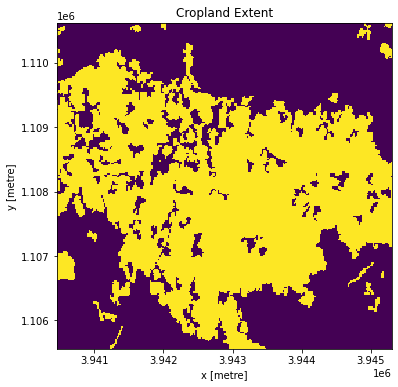

In [9]:
cm = dc.load(product='crop_mask_eastern',
            time=('2019'),
            measurements='filtered',
            resampling='nearest', 
            like=ds_a.geobox).filtered.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(6,6))
plt.title('Cropland Extent');

Now we will use the cropland map to mask the regions in the Sentinel-1 data that only have cropping

In [10]:
ds_a = ds_a.where(cm)
ds_d = ds_d.where(cm)

### False colour RGB plots
Now can plot some of the Sentinel-1 images as false colour images using the `rgb` function. Notice that the backscatter intensity of the cropping regions is changing throughout the year as the plants in the fields go through their growth and senescence cycle.

In [11]:
# VH/VV will help create an RGB image
ds_a['vh/vv'] = ds_a.vh/ds_a.vv

# median values are used to scale the measurements so they have a similar range for visualization
med_s1 = ds_a[['vv','vh','vh/vv']].median()

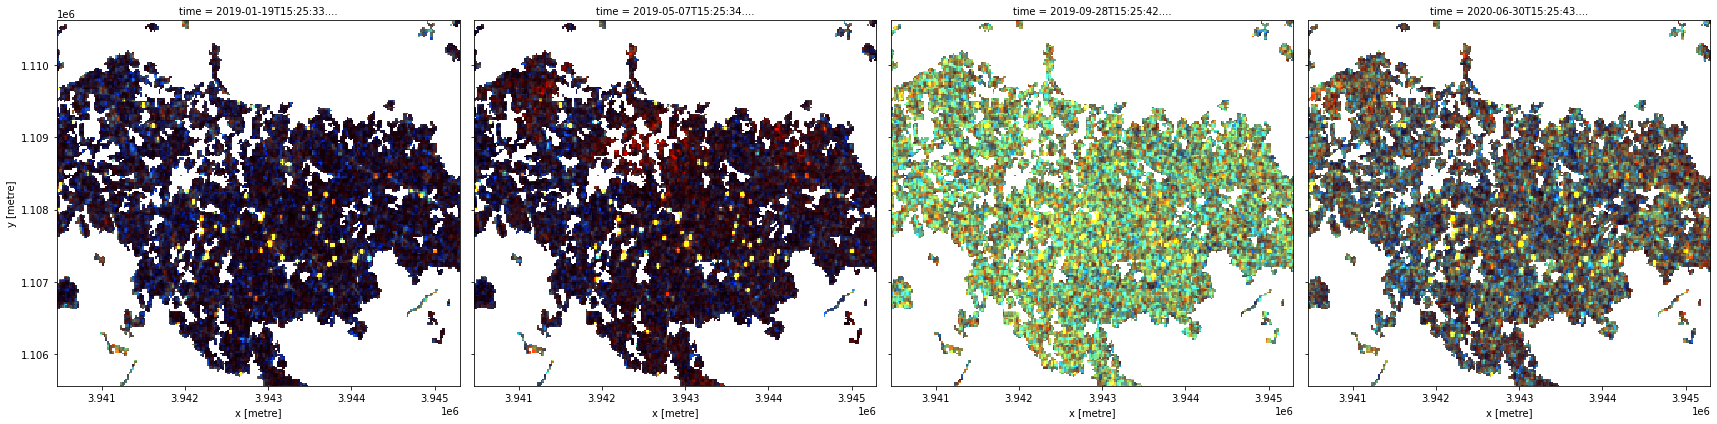

In [12]:
# plotting an RGB image for selected timesteps
time_steps = [1,10,22,45]

rgb(ds_a[['vv', 'vh', 'vh/vv']]/med_s1, #normalize image ranges
    bands=['vv','vh', 'vh/vv'],
    index=time_steps,
    col_wrap=4);

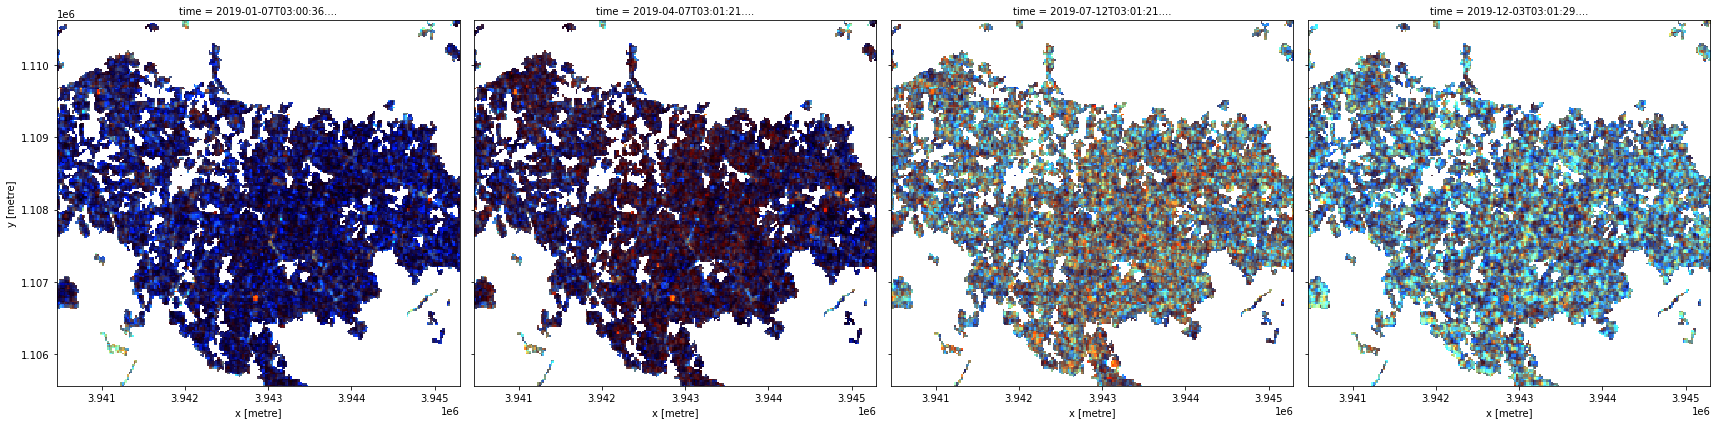

In [13]:
ds_d['vh/vv'] = ds_d.vh/ds_d.vv

rgb(ds_d[['vv', 'vh', 'vh/vv']]/med_s1, #normalize image ranges
    bands=['vv','vh', 'vh/vv'],
    index=time_steps,
    col_wrap=4);

## Compute the radar vegetation index

This study measures the presence of vegetation through either the `Radar vegetation index (RVI)`.
 
The formula is

        RVI = 4*VH/(VV+VH)

RVI is available through the `dualpol_indices` function, imported from [deafrica_tools.bandindices](../Tools/deafrica_tools/bandindices.py).

In [ ]:
index = 'VDDPI'
index = 'RVI'
#index = 'ratio'
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_a = dualpol_indices(ds_a, index=index)
ds_d = dualpol_indices(ds_d, index=index)

## Load and inspect rainfall

In [14]:
from deafrica_tools.load_era5 import load_era5

In [15]:
rainfall = load_era5('precipitation_amount_1hour_Accumulation', lat_range, lon_range, time_range, resample='1h').sum(['lat','lon']).compute()

In [16]:
start = ds_a.time.values-np.timedelta64(12, 'h')
rain_a =[]
for i in range(len(ds_a.time)):
    rain_a.append(rainfall.precipitation_amount_1hour_Accumulation.sel(time=slice(start[i], ds_a.time.values[i])).sum().values)

ds_a['rainfall']= ('time',), np.array(rain_a)

In [17]:
start = ds_d.time.values-np.timedelta64(12, 'h')
rain_d =[]
for i in range(len(ds_d.time)):
    rain_d.append(rainfall.precipitation_amount_1hour_Accumulation.sel(time=slice(start[i], ds_d.time.values[i])).sum().values)

ds_d['rainfall']= ('time',), np.array(rain_d)

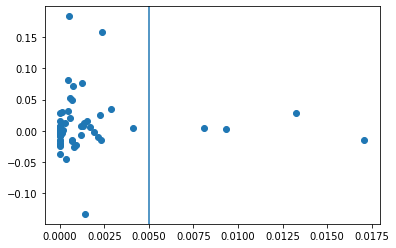

In [18]:
diff = ds_a.vv.mean(['x','y']) - ds_a.vv.rolling(time=3, min_periods=1).median().mean(['x','y'])
rain = ds_a.rainfall
plt.scatter(rain.values, diff.values)
plt.axvline(0.005)

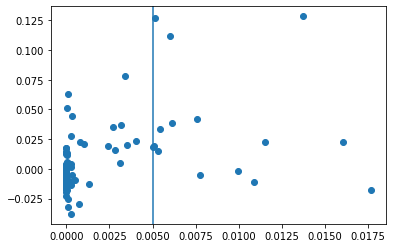

In [19]:
diff = ds_d.vv.mean(['x','y']) - ds_d.vv.rolling(time=3, min_periods=1).median().mean(['x','y'])
rain = ds_d.rainfall
plt.scatter(rain.values, diff.values)
plt.axvline(0.005)

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  

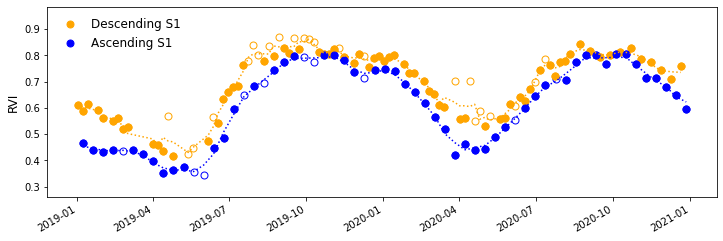

In [103]:
index = 'RVI'

rain_thresh_1 = 0.002
#rain_thresh_2 = 0.002
resample_period = '6D'
window = 3

ms = 7
dpi = None
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5), dpi=dpi)

ds_d[index].mean(['x', 'y']).plot(marker='o', linestyle='',
                                  color='orange', fillstyle='none', markersize=ms)
ds_a[index].mean(['x', 'y']).plot(marker='o', linestyle='',
                                  color='blue', fillstyle='none', markersize=ms)

#ds_d[index].where(ds_d.rainfall < rain_thresh_2).mean(
#    ['x', 'y']).plot(marker='o', linestyle='', color='orange', fillstyle='right', markersize=ms)
#ds_a[index].where(ds_a.rainfall < rain_thresh_2).mean(
#    ['x', 'y']).plot(marker='o', linestyle='', color='blue', fillstyle='right', markersize=ms)

ds_d[index].where(ds_d.rainfall < rain_thresh_1).mean(
    ['x', 'y']).plot(marker='o', linestyle='', color='orange', label='Descending S1', markersize=ms)
ds_a[index].where(ds_a.rainfall < rain_thresh_1).mean(
    ['x', 'y']).plot(marker='o', linestyle='', color='blue', label='Ascending S1', markersize=ms)

#ds_a[index].resample(time=resample_period).mean().rolling(time=window, min_periods=1).mean().mean(['x', 'y']).plot(linestyle=':', color='blue');
#ds_d[index].resample(time=resample_period).mean().rolling(time=window, min_periods=1).mean().mean(['x', 'y']).plot(linestyle=':', color='orange');

ds_a[index].mean(['x', 'y']).rolling(time=window, min_periods=1,
                                     center=True).mean().plot(linestyle=':', color='blue')
ds_d[index].mean(['x', 'y']).rolling(time=window, min_periods=1,
                                     center=True).mean().plot(linestyle=':', color='orange')

ax.set_xlabel('')
ax.set_ylabel('RVI', fontsize=12);
ax.set_title('')
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ylim = ax.set_ylim()
ax.set_ylim((ylim[0]-(ylim[1]-ylim[0])*0.1, ylim[1]+(ylim[1]-ylim[0])*0.15))
plt.legend(loc='upper left', frameon=False, fontsize=12)
fig.savefig(f'ethiopia_s1_2019_2020_phenology.eps', dpi=dpi, bbox_inches='tight',pad_inches=0)


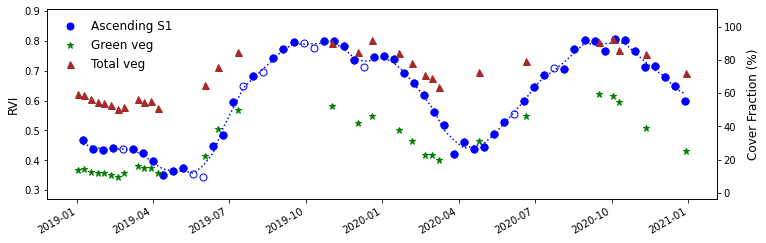

In [127]:
index = 'RVI'

rain_thresh_1 = 0.002
#rain_thresh_2 = 0.002
resample_period = '6D'
window = 3

ms = 7
dpi = None
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5), dpi=dpi)

ds_a[index].mean(['x', 'y']).plot(marker='o', linestyle='',
                                  color='blue', fillstyle='none', markersize=ms)
ds_a[index].where(ds_a.rainfall < rain_thresh_1).mean(
    ['x', 'y']).plot(marker='o', linestyle='', color='blue', label='Ascending S1', markersize=ms)

ds_a[index].mean(['x', 'y']).rolling(time=window, min_periods=1,
                                     center=True).mean().plot(linestyle=':', color='blue')
ax.set_xlabel('')
ax.set_ylabel('RVI', fontsize=12);
ax.set_title('')
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ylim = ax.set_ylim()
ax.set_ylim((ylim[0]-(ylim[1]-ylim[0])*0.1, ylim[1]+(ylim[1]-ylim[0])*0.15))
plt.legend(loc='upper left', frameon=False, fontsize=12)


ax2 = ax.twinx()
fc_clear.pv.where(cm).mean(['x','y']).plot(ax=ax2, color='green', marker='*', linestyle='', label='Green veg', markersize=ms);
#fc_clear.npv.where(cm).mean(['x','y']).plot(ax=ax2, color='blue');
#fc_clear.bs.where(cm).mean(['x','y']).plot(ax=ax2, color='red');
(fc_clear.pv+fc_clear.npv).where(cm).mean(['x','y']).plot(ax=ax2, color='brown', marker='^', linestyle='', label='Total veg', markersize=ms);

ax2.set_xlabel('')
ax2.set_ylabel('Cover Fraction (%)', fontsize=12);
ax2.set_title('')
ylim = ax2.set_ylim()
ax2.set_ylim((ylim[0]-(ylim[1]-ylim[0])*0.1, ylim[1]+(ylim[1]-ylim[0])*0.15))
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9), frameon=False, fontsize=12)


fig.savefig(f'ethiopia_s1_2019_2020_phenology_fc.eps', dpi=dpi, bbox_inches='tight',pad_inches=0)

## Smoothing/Interpolating vegetation time-series

Here, we will smooth and interpolate the data to ensure we working with a consistent time-series. This is a very important step in the workflow and there are many ways to smooth, interpolate, gap-fill, remove outliers, or curve-fit the data to ensure a useable time-series. If not using the default example, you may have to define additional methods to those used here.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the fortnightly median
2. Calculate a rolling mean with a window of 4 steps


In [16]:
#resample_period='12D'
window=3

rvi_smooth = ds_a[index].rolling(time=window, min_periods=1, center=True).mean()


Plot the smoothed and interpolated time-series

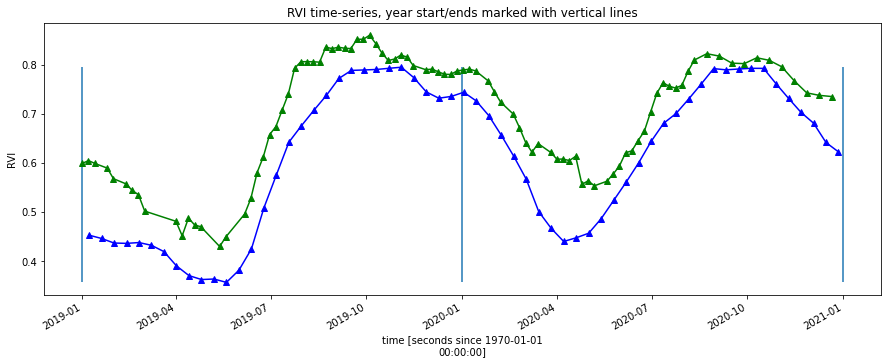

In [17]:
rvi_smooth_1D = ds_a[index].mean(['x', 'y']).rolling(time=window, min_periods=1, center=True).mean()
rvi_smooth_1D_d = ds_d[index].mean(['x', 'y']).rolling(time=window, min_periods=1, center=True).mean()
rvi_smooth_1D.plot.line('b-^', figsize=(15,5))
rvi_smooth_1D_d.plot.line('g-^')
_max=rvi_smooth_1D.max()
_min=rvi_smooth_1D.min()
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.title('RVI time-series, year start/ends marked with vertical lines')
plt.ylabel('RVI');

## Calculate phenology statistics using `xr_phenology`

The DE Africa function `xr_phenology` can calculate a number of land-surface phenology statistics that together describe the characteristics of a plant's lifecycle.  The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis:

            SOS = DOY of start of season
            POS = DOY of peak of season
            EOS = DOY of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (DOY)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

where DOY = day-of-year (Jan 1st = 0, Dec 31st = 365).  By default the function will return all the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

See the [deafrica_tools.temporal](../Tools/deafrica_tools/temporal.py) script for more information on each of the parameters in `xr_phenology`.


### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal mean (mean of all pixels in the image) time-series to the function and plot the results on the same curves as above.

First, provide a list of statistics to calculate with the parameter, `pheno_stats`.

`method_sos` : If 'first' then vSOS is estimated as the first positive slope on the greening side of the curve. If 'median', then vSOS is estimated as the median value of the postive slopes on the greening side of the curve.

`method_eos` : If 'last' then vEOS is estimated as the last negative slope on the senescing side of the curve. If 'median', then vEOS is estimated as the 'median' value of the negative slopes on the senescing side of the curve.

In [18]:
pheno_stats = ['SOS','vSOS','POS','vPOS','EOS','vEOS','Trough','LOS','AOS','ROG','ROS']
method_sos = 'first'
method_eos = 'last'

In [56]:
season_start = 4

# find all the years to assist with plotting
years=rvi_smooth_1D.groupby('time.year')

# get list of years in ts to help with looping
years_int=[y[0] for y in years]

#store results in dict
pheno_results = {}

#loop through years and calculate phenology
for year in years_int:
    #select year
    da = dict(years)[year].isel(time= (dict(years)[year].time.values.astype('datetime64[M]').astype(int)%12+1>= season_start))
    
    #calculate stats
    stats=xr_phenology(
            da,
            method_sos=method_sos,
            method_eos=method_eos,
            stats=pheno_stats,
            verbose=False
                )
    #add results to dict    
    pheno_results[str(year)] = stats
    
for key,value in pheno_results.items():
    print('Year: ' +key)
    for b in value.data_vars:
        print("   "+b+": ", round(float(value[b].values),3))

Year: 2019
   SOS:  139.0
   vSOS:  0.357
   POS:  307.0
   vPOS:  0.795
   EOS:  343.0
   vEOS:  0.732
   Trough:  0.357
   LOS:  204.0
   AOS:  0.437
   ROG:  0.003
   ROS:  -0.002
Year: 2020
   SOS:  122.0
   vSOS:  0.457
   POS:  278.0
   vPOS:  0.793
   EOS:  362.0
   vEOS:  0.623
   Trough:  0.457
   LOS:  240.0
   AOS:  0.335
   ROG:  0.002
   ROS:  -0.002


Plot the results with our statistcs annotated on the plot

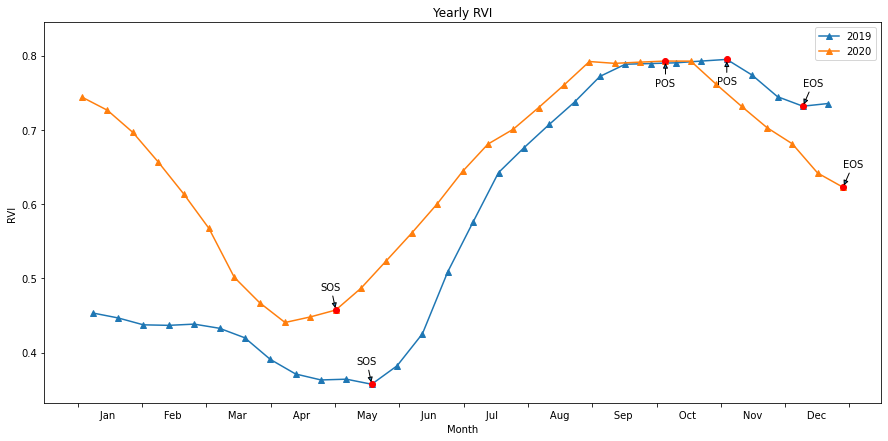

In [57]:
# find all the years to assist with plotting
years=rvi_smooth_1D.groupby('time.year')

fig, ax = plt.subplots()
fig.set_size_inches(15,7)
for year, y in zip(years, years_int):
    #grab tall the values we need for plotting
    eos = pheno_results[str(y)].EOS.values
    sos = pheno_results[str(y)].SOS.values
    pos = pheno_results[str(y)].POS.values

    veos = pheno_results[str(y)].vEOS.values
    vsos = pheno_results[str(y)].vSOS.values
    vpos = pheno_results[str(y)].vPOS.values
    
    #create plot
    #the groupby and mean below doesn't actually do anything, except allow
    #the plots to be on the same x-axis. i.e. veg-data isn't modified, just time units
    year[1].groupby('time.dayofyear').mean().plot(ax=ax, label=year[0], marker='^')

    #add start of season
    ax.plot(sos, vsos, 'or')
    ax.annotate('SOS',
                xy=(sos, vsos),
                xytext=(-15, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add end of season
    ax.plot(eos, veos, 'or')
    ax.annotate('EOS',
                xy=(eos, veos),
                xytext=(0, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add peak of season
    ax.plot(pos, vpos, 'or')
    ax.annotate('POS',
                xy=(pos, vpos),
                xytext=(-10, -25),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

ax.legend()
plt.ylim(_min-0.025,_max.values+0.05)
month_abbr=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec', '']
new_m=[]
for m in month_abbr:
    new_m.append('       %s'%m) #Add spaces before the month name
plt.xticks(np.linspace(0,365,13), new_m, horizontalalignment='left')
plt.xlabel('Month')
plt.ylabel('RVI')
plt.title('Yearly RVI');

## Per-pixel phenology statistics

We can now calculate the statistics for every pixel in our time-series and plot the results.

In [58]:
# find all the years to assist with plotting
years=rvi_smooth.groupby('time.year')

# get list of years in ts to help with looping
years_int=[y[0] for y in years]

#store results in dict
pheno_results = {}

#loop through years and calculate phenology
for year in years_int:
    #select year
    #da = dict(years)[year]
    da = dict(years)[year].isel(time= (dict(years)[year].time.values.astype('datetime64[M]').astype(int)%12+1>= season_start))
    
    #calculate stats
    stats=xr_phenology(
            da,
            method_sos=method_sos,
            method_eos=method_eos,
            stats=pheno_stats,
            verbose=False
                )
    #add results to dict    
    pheno_results[str(year)] = stats

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

Below, pick a year from the phenology results to plot. 

In [60]:
#Pick a year to plot
year_to_plot = '2020'

At the top if the plotting code we re-mask the phenology results with the crop-mask. This is because `xr_phenology`has methods for handling pixels with only NaNs (such as those regions outside of the polygon mask), so the results can have phenology results for regions outside the mask. We will therefore have to mask the data again.


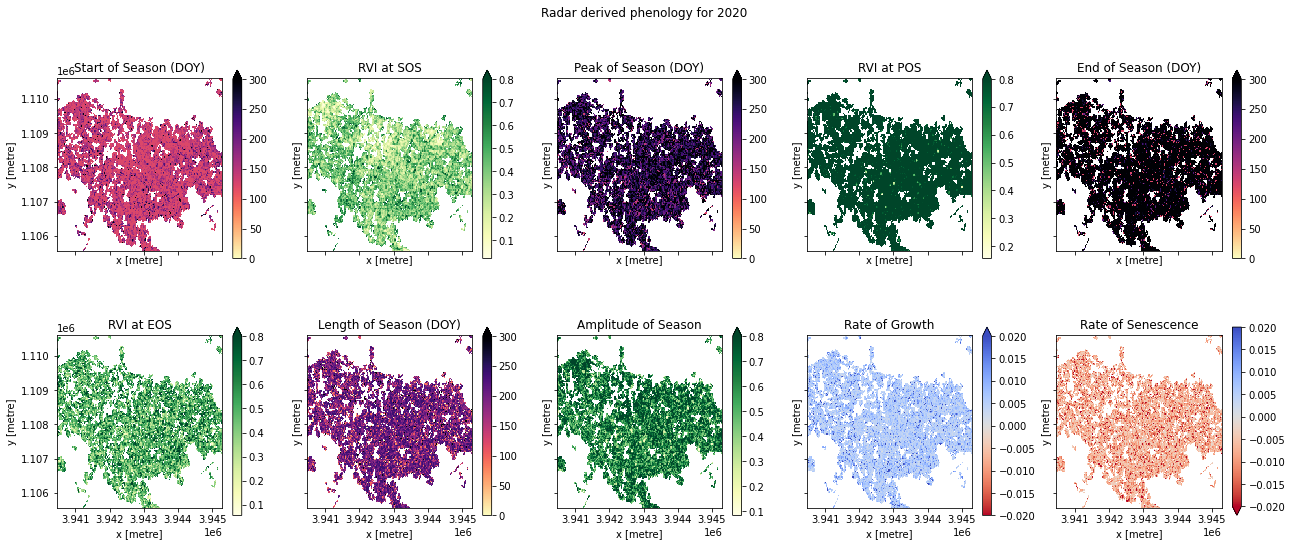

In [61]:
#select the year to plot
phen = pheno_results[year_to_plot]

#mask again with crop-mask
phen = phen.where(cm)

# set up figure
fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(18, 8),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# start of season
phen.SOS.plot(ax=ax[0, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')

phen.vSOS.plot(ax=ax[0, 1],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title('RVI at SOS')

# peak of season
phen.POS.plot(ax=ax[0, 2],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 2].set_title('Peak of Season (DOY)')
phen.vPOS.plot(ax=ax[0, 3],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 3].set_title('RVI at POS')

# end of season
phen.EOS.plot(ax=ax[0, 4],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 4].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[1, 0],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title('RVI at EOS')

# Length of Season
phen.LOS.plot(ax=ax[1, 1],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot(ax=ax[1, 2],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 2].set_title('Amplitude of Season')

# rate of growth
phen.ROG.plot(ax=ax[1, 3],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 3].set_title('Rate of Growth')

# rate of Sensescence
phen.ROS.plot(ax=ax[1, 4],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 4].set_title('Rate of Senescence')
plt.suptitle('Radar derived phenology for '+year_to_plot)
plt.tight_layout();

In [66]:
phen.POS.quantile([0.1,0.9])

<xarray.DataArray 'POS' (quantile: 2)>
array([194., 338.])
Coordinates:
  * quantile  (quantile) float64 0.1 0.9

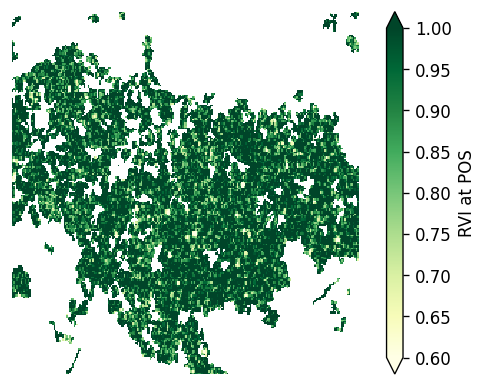

In [71]:
dpi =120 

#select the year to plot
phen = pheno_results[year_to_plot]
phen = phen.where(cm)

fig, ax = plt.subplots(1, 1, dpi=dpi)
phen.vPOS.plot(ax=ax,
               cmap='YlGn',
               vmin =0.6, vmax=1,
               #robust=True,
               cbar_kwargs=dict(label='RVI at POS')
              )

ax.set_aspect('equal')
ax.set_title('')
ax.axis('off')
fig.savefig(f'ethiopia_s1_{year_to_plot}_rvi_pos.eps', dpi=dpi, bbox_inches='tight',pad_inches=0)


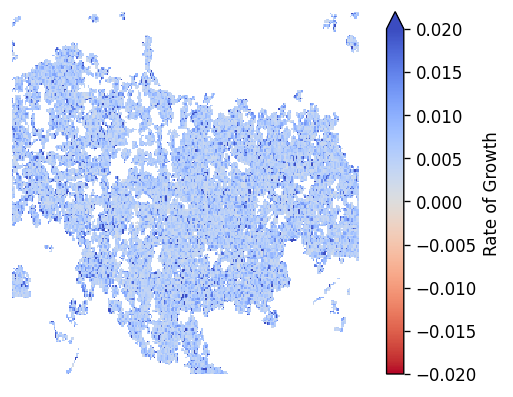

In [72]:
#select the year to plot
phen = pheno_results[year_to_plot]

fig, ax = plt.subplots(1, 1, dpi=dpi)
phen.ROG.plot(ax=ax,
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(label='Rate of Growth'))
ax.set_aspect('equal')
ax.set_title('')
ax.axis('off')
fig.savefig(f'ethiopia_s1_{year_to_plot}_rog.eps', dpi=dpi, bbox_inches='tight',pad_inches=0)


## Make a S2 snapshot

In [ ]:
bands = ['swir_1','nir','green']
s2_snapshot = load_ard(dc=dc,
              products=["s2_l2a"],
              measurements=bands,
              y=lat_range,
              x=lon_range,
              time=('2020-05', '2020-09'),
              output_crs = "EPSG:4326",
              resolution = (0.0001,0.0001),
              group_by="solar_day",
              dtype='native',
              min_gooddata=0.95, 
             )
print(s2_snapshot.time.values)
s2_snapshot[bands].to_array().plot.imshow(col='time');

In [ ]:
idx=0
fig, ax = plt.subplots(1, 1, dpi=dpi)
(s2_snapshot[bands].isel(time=idx).to_array(dim='band')).plot.imshow(robust=True, ax=ax);
ax.set_aspect('equal');
ax.set_title('');
ax.set_xlabel('Longitude', fontsize=12);
ax.set_ylabel('Latitude', fontsize=12);
#ax.axis('off');
fig.savefig(f'ethiopia_s2_{str(s2_snapshot.time.values[idx])[:10]}.eps', dpi=dpi, bbox_inches='tight',pad_inches=0)

## Conclusions

In the example above, we can see most of the fields are following a similar cropping schedule and are therefore likely the same species of crop. We can also observe that some fields have not followed this schedule (e.g. the EOY plot shows some fields didn't follow this schedule, probably because they either remained fallow during the year, or because there were two peaks during the year which may have confused the phenology stats).  Differences in the rates of growth, and in the RVI values at different times of the season, may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  Per-pixel plots of phenology can help us understand the timing of vegetation growth and sensecence across large areas and across diverse plant species as every pixel is treated as an independent series of observations. This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')